In [1]:
import pickle, random
from itertools import product

PATH = "scripts/vocabs/stats/"
def dict_save(vocab):
    with open(PATH + 'vocab.pickle', 'wb') as f:
        pickle.dump(vocab, f, pickle.HIGHEST_PROTOCOL)

def dict_load():
    with open(PATH + 'vocab.pickle', 'rb') as f:
        return pickle.load(f)

In [ ]:
import random, pickle, ast
from itertools import product
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from transformers import GPT2Config, GPT2ForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, GPT2Config
from collections import Counter
import torch.nn as nn
from sklearn.metrics import accuracy_score
import random, os

vocab = dict_load()

def tokenizer(input_array):
    padding, bos, eos, sep = 5, 1, 7, 2
    maxLen = 27
    input_array_final = []
    attention_mask_final = []
    last_non_pad_indexes = []

    for input in input_array:
        data = input.strip().split('|')
        
        true_subs_one_hot = ast.literal_eval(data[1])
        est_subs_one_hot = ast.literal_eval(data[3])
        true_subs_tokenized = [0] * len(true_subs_one_hot)
        est_subs_tokenized = [0] * len(true_subs_one_hot)

        # Prepare True sub order
        for i in range(len(true_subs_one_hot)):
            one_hot = tuple(true_subs_one_hot[i])
            token_val = vocab[one_hot]
            true_subs_tokenized[i] = token_val

        # Prepare est sub order
        for i in range(len(est_subs_one_hot)):
            one_hot = tuple(est_subs_one_hot[i])
            token_val = vocab[one_hot]
            est_subs_tokenized[i] = token_val

        # Prepare full vector and attention_mask
        input_array_tokenized = [0] * maxLen
        attention_mask = [0] * maxLen
        input_array_tokenized[0] = bos # adding left side padding
        attention_mask[0] = 1
        index = 1
        for i in range(len(true_subs_tokenized)): # adding truesubs
            input_array_tokenized[index] = true_subs_tokenized[i]
            attention_mask[index] = 1
            index += 1
        input_array_tokenized[index] = sep
        attention_mask[index] = 1
        index += 1
        for i in range(len(est_subs_tokenized)): # adding estsubs
            input_array_tokenized[index] = est_subs_tokenized[i]
            attention_mask[index] = 1
            index += 1
        
        input_array_tokenized[index] = eos
        attention_mask[index] = 1
        index += 1
        
        # Adjust padding
        pad_required = maxLen - index
        for i in range(pad_required):
            input_array_tokenized[index] = padding
            index += 1
        # print(input_array_tokenized, attention_mask)
        input_array_final.append(input_array_tokenized)
        attention_mask_final.append(attention_mask)
        last_non_pad_idx = input_array_tokenized.index(eos)
        last_non_pad_indexes.append(last_non_pad_idx)
    
    # now converting to tensor
    input_tensor = torch.tensor(input_array_final) 
    attention_mask_tensor = torch.tensor(attention_mask_final)
    last_non_pad_indexes_tensor = torch.tensor(last_non_pad_indexes)
    # print(input_tensor.shape)
    tensor_dict = {'input_ids' : input_tensor, 'attention_mask' : attention_mask_tensor }

    return tensor_dict, last_non_pad_indexes_tensor

In [3]:
# Create a new GPT-2 configuration for initializing the model from scratch
config = GPT2Config(
    vocab_size=300,  # Matching the tokenizer's vocab size
    n_positions=27,
    n_ctx=27,
    n_embd=128,  # Reduced embedding size
    n_layer=4,   # Fewer layers
    n_head=8,    # Fewer attention heads
    num_labels=2,  # Adjust based on your classification task, e.g., binary classification
    problem_type = "single_label_classification",
    pad_token_id = 5,
    bos_token_id = 1,
    eos_token_id = 7,
    additional_special_tokens = 2
)

model = GPT2ForSequenceClassification(config=config)
model.config.id2label = {0: 'Optimal', 1: 'SubOptimal'}
model.config.label2id = {'Optimal': 0, 'SubOptimal': 1}

# Define the MLP
class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        return self.layer2(x)

mlp = MyMLP(input_size=128 + 1, hidden_size=128, output_size=2)

In [4]:
def calculate_accuracy(true_labels, predicted_labels):
    correct_predictions = (true_labels == predicted_labels).sum()
    accuracy = correct_predictions / true_labels.shape[0]
    return accuracy.item()  # Convert from tensor to a Python float

def predict(inputs, qry_lvl_l1_tensor, last_non_pad_indexes_tensor, label_tensor):
    # Load the best MLP model state if it's saved separately
    best_mlp_model_path = "STATS-CEB-SCALE_classification_model.pth"

    # Convert inputs and labels into a PyTorch Dataset and DataLoader
    dataset_1 = TensorDataset(inputs['input_ids'], inputs['attention_mask'], qry_lvl_l1_tensor, last_non_pad_indexes_tensor, label_tensor)

    # Create DataLoaders for training and test sets
    test_dataloader = DataLoader(dataset_1, batch_size=8, shuffle=False)


    # # Load the combined state dictionary
    combined_state_dict = torch.load(best_mlp_model_path)
    mlp_state_dict = combined_state_dict['mlp_state_dict']
    model_state_dict = combined_state_dict['model_state_dict']
    model.load_state_dict(model_state_dict)
    mlp.load_state_dict(mlp_state_dict)


    # Ensure both models are in evaluation mode
    model.eval()
    mlp.eval()

    true_pred_pairs = []
    true_labels_list = []
    predicted_labels_list = []

    with torch.no_grad():
        for batch in test_dataloader:  # Assuming test_dataloader is for validation
            input_ids, attention_mask, qry_lvl_l1, last_non_pad_idx, labels = batch
            
            # Get outputs from the GPT-2 model
            # outputs = model(input_ids, attention_mask=attention_mask)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels, output_hidden_states=True)
            
            # Extract hidden states; assume you need the last hidden state
            hidden_states = outputs.hidden_states[-1]  # Last layer's hidden states
            qry_lvl_l1 = qry_lvl_l1.float()
            qry_lvl_l1 = qry_lvl_l1.unsqueeze(-1)  # Reshape to [batch_size, 1] if necessary
            combined_input_list = []
            for i, idx in enumerate(last_non_pad_idx):
                hidden_state_selected = hidden_states[i, idx.item(), :]  # Use .item() to get Python int
                qry_lvl_l1_expanded = qry_lvl_l1[i].unsqueeze(-1)  # Add an extra dimension to make it [1, 1]
                combined_input = torch.cat((hidden_state_selected.unsqueeze(0), qry_lvl_l1_expanded), dim=1)
                combined_input_list.append(combined_input)

            combined_input = torch.cat(combined_input_list, dim=0).float()  # Ensure combined_input is Float
            mlp_output = mlp(combined_input) # Pass the combined input through the MLP
            probs = torch.nn.functional.softmax(mlp_output, dim=-1) # Convert logits to probabilities (optional)
            predictions = torch.argmax(probs, dim=-1) # Predictions based on the highest probability
            
            # Store true label and predicted label
            pairs = list(zip(labels.cpu().numpy(), predictions.cpu().numpy()))
            true_pred_pairs.extend(pairs)

            # Store true and predicted labels for accuracy calculation
            true_labels_list.append(labels)
            predicted_labels_list.append(predictions)

    # Concatenate all batches' true and predicted labels
    all_true_labels = torch.cat(true_labels_list)
    all_predicted_labels = torch.cat(predicted_labels_list)

    # Calculate validation accuracy
    validation_accuracy = calculate_accuracy(all_true_labels.cpu().numpy(), all_predicted_labels.cpu().numpy())
    print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

    return true_pred_pairs

In [6]:
# load other dataset
fileLocation = "stats/tc_reversed/"

trueCard_file = fileLocation + "l1_with_pos_vec_tc_reversed_1_2_way.csv"
deepdb_0_dataset_file = fileLocation + "l1_with_pos_vec_tc_reversed_0_2_way.csv"
deepdb_25_dataset_file = fileLocation + "l1_with_pos_vec_tc_reversed_0.25_2_way.csv"
deepdb_50_dataset_file = fileLocation + "l1_with_pos_vec_tc_reversed_0.5_2_way.csv"
deepdb_75_dataset_file = fileLocation + "l1_with_pos_vec_tc_reversed_0.75_2_way.csv"

# Load data in pandas dataframe
data_trueCard = pd.read_csv(trueCard_file)
data_deepdb0 = pd.read_csv(deepdb_0_dataset_file)
data_deepdb25 = pd.read_csv(deepdb_25_dataset_file)
data_deepdb50 = pd.read_csv(deepdb_50_dataset_file)
data_deepdb75 = pd.read_csv(deepdb_75_dataset_file)

# create input array
zero_vector = "[[0, 0, 0, 0, 0, 0]]" # Adjust the size of the zero vector as needed
input_array_trueCard = [zero_vector + '|' + true_subs_vec + '|' + zero_vector + '|' + est_subs_vec + '|' + zero_vector 
               for true_subs_vec, est_subs_vec in zip(data_trueCard['true_subs_vec'], data_trueCard['est_subs_vec'])]
input_array_deepdb0 = [zero_vector + '|' + true_subs_vec + '|' + zero_vector + '|' + est_subs_vec + '|' + zero_vector 
               for true_subs_vec, est_subs_vec in zip(data_deepdb0['true_subs_vec'], data_deepdb0['est_subs_vec'])]
input_array_deepdb25 = [zero_vector + '|' + true_subs_vec + '|' + zero_vector + '|' + est_subs_vec + '|' + zero_vector 
               for true_subs_vec, est_subs_vec in zip(data_deepdb25['true_subs_vec'], data_deepdb25['est_subs_vec'])]
input_array_deepdb50 = [zero_vector + '|' + true_subs_vec + '|' + zero_vector + '|' + est_subs_vec + '|' + zero_vector 
               for true_subs_vec, est_subs_vec in zip(data_deepdb50['true_subs_vec'], data_deepdb50['est_subs_vec'])]
input_array_deepdb75 = [zero_vector + '|' + true_subs_vec + '|' + zero_vector + '|' + est_subs_vec + '|' + zero_vector 
               for true_subs_vec, est_subs_vec in zip(data_deepdb75['true_subs_vec'], data_deepdb75['est_subs_vec'])]

# Tokenize inputFile
input_tensor_dict_trueCard, last_non_pad_indexes_tensor_trueCard = tokenizer(input_array_trueCard)
input_tensor_dict_deepdb0, last_non_pad_indexes_tensor_deepdb0 = tokenizer(input_array_deepdb0)
input_tensor_dict_deepdb25, last_non_pad_indexes_tensor_deepdb25 = tokenizer(input_array_deepdb25)
input_tensor_dict_deepdb50, last_non_pad_indexes_tensor_deepdb50 = tokenizer(input_array_deepdb50)
input_tensor_dict_deepdb75, last_non_pad_indexes_tensor_deepdb75 = tokenizer(input_array_deepdb75)

inputs_trueCard = {key: val.clone().detach().to(torch.long) for key, val in input_tensor_dict_trueCard.items()}
inputs_deepdb0 = {key: val.clone().detach().to(torch.long) for key, val in input_tensor_dict_deepdb0.items()}
inputs_deepdb25 = {key: val.clone().detach().to(torch.long) for key, val in input_tensor_dict_deepdb25.items()}
inputs_deepdb50 = {key: val.clone().detach().to(torch.long) for key, val in input_tensor_dict_deepdb50.items()}
inputs_deepdb75 = {key: val.clone().detach().to(torch.long) for key, val in input_tensor_dict_deepdb75.items()}

# process label and query level l1 column
id2label = {0: 'Optimal', 1: 'SubOptimal'}
label2id = {'Optimal': 0, 'SubOptimal': 1}

data_trueCard['label'] = data_trueCard['label'].map(label2id).astype(np.int64)
data_trueCard['qry_lvl_l1'] = data_trueCard['qry_lvl_l1'].astype(np.float64)
label_array_trueCard = data_trueCard['label'].values
label_tensor_trueCard = torch.tensor(label_array_trueCard, dtype=torch.long)
qry_lvl_l1_array_trueCard = data_trueCard['qry_lvl_l1'].values
qry_lvl_l1_tensor_trueCard = torch.tensor(qry_lvl_l1_array_trueCard, dtype=torch.float)

data_deepdb0['label'] = data_deepdb0['label'].map(label2id).astype(np.int64)
data_deepdb0['qry_lvl_l1'] = data_deepdb0['qry_lvl_l1'].astype(np.float64)
label_array_deepdb0 = data_deepdb0['label'].values
label_tensor_deepdb0 = torch.tensor(label_array_deepdb0, dtype=torch.long)
qry_lvl_l1_array_deepdb0 = data_deepdb0['qry_lvl_l1'].values
qry_lvl_l1_tensor_deepdb0 = torch.tensor(qry_lvl_l1_array_deepdb0, dtype=torch.float)


data_deepdb25['label'] = data_deepdb25['label'].map(label2id).astype(np.int64)
data_deepdb25['qry_lvl_l1'] = data_deepdb25['qry_lvl_l1'].astype(np.float64)
label_array_deepdb25 = data_deepdb25['label'].values
label_tensor_deepdb25 = torch.tensor(label_array_deepdb25, dtype=torch.long)
qry_lvl_l1_array_deepdb25 = data_deepdb25['qry_lvl_l1'].values
qry_lvl_l1_tensor_deepdb25 = torch.tensor(qry_lvl_l1_array_deepdb25, dtype=torch.float)

data_deepdb50['label'] = data_deepdb50['label'].map(label2id).astype(np.int64)
data_deepdb50['qry_lvl_l1'] = data_deepdb50['qry_lvl_l1'].astype(np.float64)
label_array_deepdb50 = data_deepdb50['label'].values
label_tensor_deepdb50 = torch.tensor(label_array_deepdb50, dtype=torch.long)
qry_lvl_l1_array_deepdb50 = data_deepdb50['qry_lvl_l1'].values
qry_lvl_l1_tensor_deepdb50 = torch.tensor(qry_lvl_l1_array_deepdb50, dtype=torch.float)

data_deepdb75['label'] = data_deepdb75['label'].map(label2id).astype(np.int64)
data_deepdb75['qry_lvl_l1'] = data_deepdb75['qry_lvl_l1'].astype(np.float64)
label_array_deepdb75 = data_deepdb75['label'].values
label_tensor_deepdb75 = torch.tensor(label_array_deepdb75, dtype=torch.long)
qry_lvl_l1_array_deepdb75 = data_deepdb75['qry_lvl_l1'].values
qry_lvl_l1_tensor_deepdb75 = torch.tensor(qry_lvl_l1_array_deepdb75, dtype=torch.float)

In [ ]:
import time
pred_start_time = time.perf_counter()
true_pred_pairs = predict(inputs_trueCard, qry_lvl_l1_tensor_trueCard, last_non_pad_indexes_tensor_trueCard, label_tensor_trueCard)
pred_end_time = time.perf_counter()
print("Prediction Time : ", pred_end_time - pred_start_time, "seconds")
print("AVG prediction Time : ", (pred_end_time - pred_start_time) / 2380, "seconds")


true_pred_pairs_deepdb0 = predict(inputs_deepdb0, qry_lvl_l1_tensor_deepdb0, last_non_pad_indexes_tensor_deepdb0, label_tensor_deepdb0)
true_pred_pairs_deepdb25 = predict(inputs_deepdb25, qry_lvl_l1_tensor_deepdb25, last_non_pad_indexes_tensor_deepdb25, label_tensor_deepdb25)
true_pred_pairs_deepdb50 = predict(inputs_deepdb50, qry_lvl_l1_tensor_deepdb50, last_non_pad_indexes_tensor_deepdb50, label_tensor_deepdb50)
true_pred_pairs_deepdb75 = predict(inputs_deepdb75, qry_lvl_l1_tensor_deepdb75, last_non_pad_indexes_tensor_deepdb75, label_tensor_deepdb75)

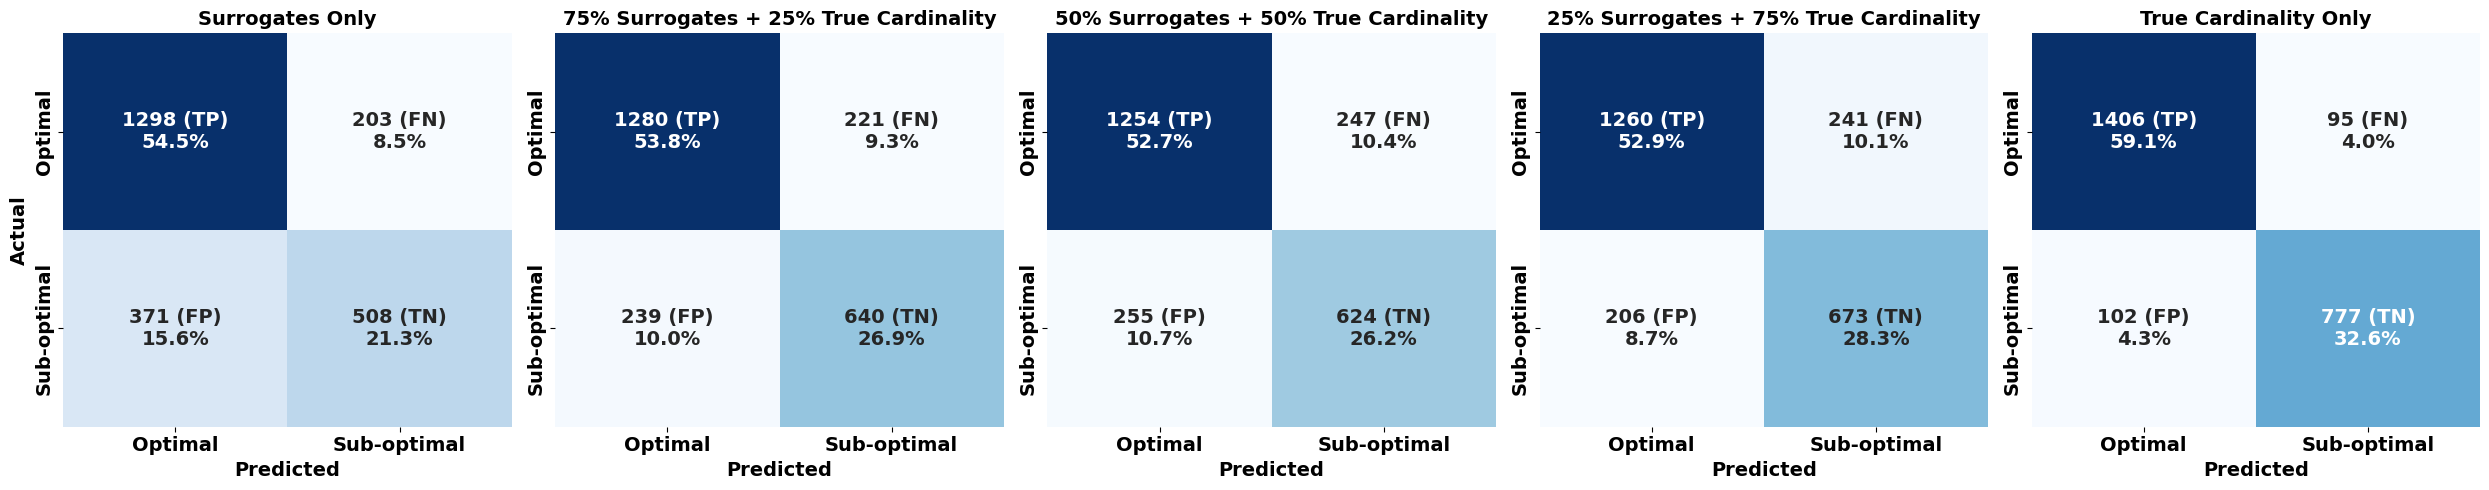

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# List of all true_pred_pairs with Training moved to the end
all_true_pred_pairs = [
    true_pred_pairs_deepdb0,
    true_pred_pairs_deepdb25,
    true_pred_pairs_deepdb50,
    true_pred_pairs_deepdb75,
    true_pred_pairs  # Training moved to the end
]

# Titles for the subplots with Training moved to the end
titles = ['Surrogates Only', '75% Surrogates + 25% True Cardinality', '50% Surrogates + 50% True Cardinality', '25% Surrogates + 75% True Cardinality', 'True Cardinality Only']

# Set up the matplotlib figure
plt.figure(figsize=(25, 5))  # Adjusting size to ensure readability in a single row
total_queries = 2380
for i, pairs in enumerate(all_true_pred_pairs, 1):
    plt.subplot(1, 5, i)
    true_labels, predictions = zip(*pairs)  # Unpack the list of tuples
    cm = confusion_matrix(true_labels, predictions)
    
    # Calculate the percentage for each category
    tp_percentage = (cm[0][0] / total_queries) * 100
    fn_percentage = (cm[0][1] / total_queries) * 100
    fp_percentage = (cm[1][0] / total_queries) * 100
    tn_percentage = (cm[1][1] / total_queries) * 100

    # Create annotations with both the count and the percentage
    annot = [[f'{cm[0][0]} (TP)\n{tp_percentage:.1f}%', f'{cm[0][1]} (FN)\n{fn_percentage:.1f}%'],
             [f'{cm[1][0]} (FP)\n{fp_percentage:.1f}%', f'{cm[1][1]} (TN)\n{tn_percentage:.1f}%']]
    
    cbar = i == len(all_true_pred_pairs)
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', 
                xticklabels=['Optimal', 'Sub-optimal'], 
                yticklabels=['Optimal', 'Sub-optimal'], 
                cbar=False, annot_kws={"size": 14, "weight": "bold"})  # Adjust annotation size and weight for readability
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.ylabel('Actual' if i == 1 else '', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=14, fontweight='bold')
    plt.title(titles[i-1], fontsize=14, fontweight='bold')  # Slightly larger font size and bold for titles

plt.tight_layout()
# Save the figure to a PDF file
plt.savefig('confusion_matrix_stats_tc_reversed.pdf', format='pdf')

plt.show()
